<a href="https://colab.research.google.com/github/arivv22/Medical-AI-Pneumonia-Classification/blob/master/Medical_AI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviroment

In [22]:
# Install dependencies (jalankan sekali saja)
!pip install torch torchvision scikit-learn matplotlib seaborn kaggle


# Import Library

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# Download Dataset (Chest X-Ray)


*   You need have kaggle acount and have kaggle.json
*   Upload kaggle.json to your folder
*   Downloada dataset


In [24]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#if you already download dataset. then skip this code
# Download dataset Chest X-ray Pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Extract dataset
unzip chest-xray-pneumonia.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
User cancelled operation
Archive:  chest-xray-pneumonia.zip
replace data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Preparation

Expected output


```
Classes: ['NORMAL', 'PNEUMONIA']
```



In [25]:
data_dir = "data/chest_xray"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)


Classes: ['NORMAL', 'PNEUMONIA']


Using this code below if you want quick demo the project

using gpu if you more faster or adjust epoch train model

In [26]:
from torch.utils.data import Subset
import numpy as np

subset_indices = np.random.choice(len(train_data), 1000, replace=False)
train_small = Subset(train_data, subset_indices)
train_loader = DataLoader(train_small, batch_size=16, shuffle=True, num_workers=2)

# Load Pretrained Model (ResNet18)

In [27]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Train the Model

Epoch [1/2], Loss: 0.3650
Epoch [2/2], Loss: 0.2301


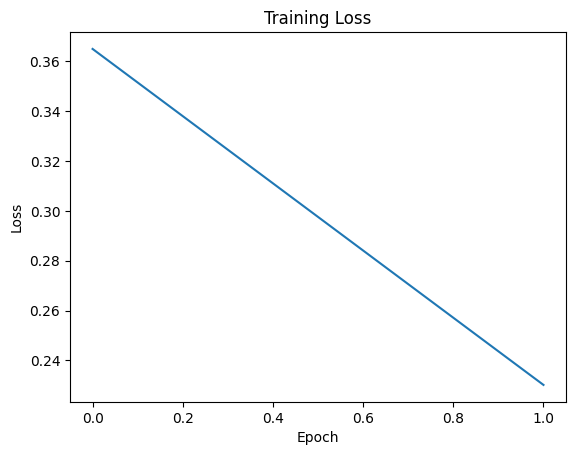

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 2
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Evaluate the Model

In [29]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.47      0.63       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



# Confusion Matrix

In [30]:
import os

os.makedirs("docs", exist_ok=True)

plt.savefig("docs/confusion_matrix.png")


<Figure size 640x480 with 0 Axes>

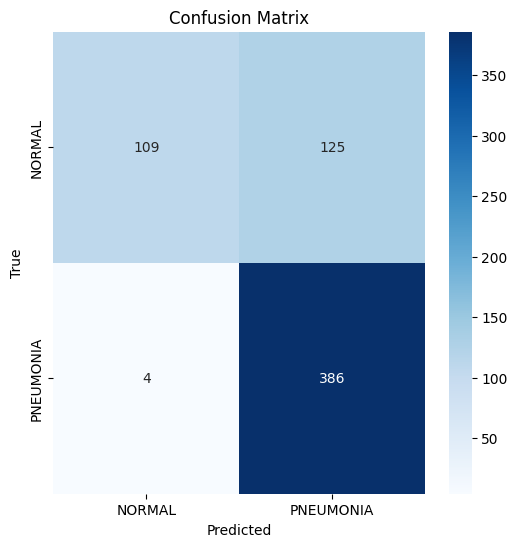

In [31]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("docs/confusion_matrix.png")
plt.show()


# 9. Sample Prediction Visualization

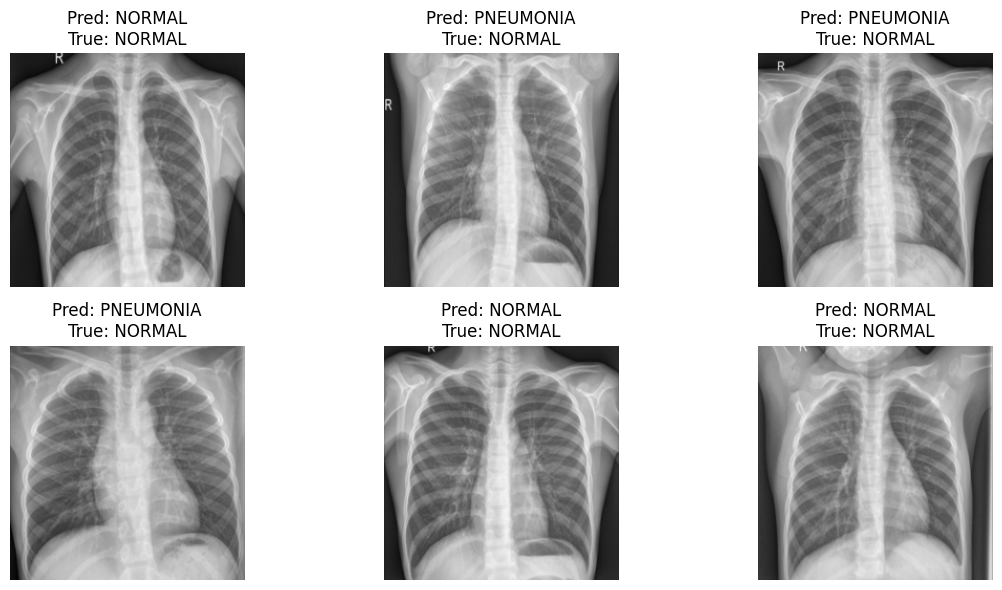

In [32]:
def show_sample_predictions(model, loader, n=6):
    model.eval()
    images, labels = next(iter(loader))
    images = images[:n]
    labels = labels[:n]
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) +
               np.array([0.485, 0.456, 0.406]))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("docs/sample_predictions.png")
    plt.show()

show_sample_predictions(model, test_loader)


# Save Model & Push ke GitHub

In [33]:
torch.save(model.state_dict(), "medical_xray_resnet18.pth")
